In [1]:
import tensorflow as tf

In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
length = 50
valid_frac = 0.15
test_frac  = 0.05
train_frac = 1.0 - (valid_frac + test_frac)

weight_path = "C:/Users/drop/Documents/project/weights/lstm_lstm/"

In [4]:
import time
import math
import operator
import datetime
import threading
import scipy as sp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.interpolate
from scipy.signal import find_peaks, savgol_filter

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Bidirectional, Dense, Flatten, TimeDistributed

plt.rcParams["figure.figsize"] = (14,7)

In [5]:
dataset_dir = "C:/Users/drop/Documents/project/dataset"
extracted_dir  = f"{dataset_dir}/extracted/"
labels_path = f"{dataset_dir}/relative_labels.csv"
labels = pd.read_csv(labels_path)
print(f"label dataframe object structure: {labels.columns.tolist()}")

label dataframe object structure: ['Unnamed: 0', 'directory', 'file_name', 'extension', 'ed', 'es']


In [6]:
data_size = len(labels)

train_size = int(data_size * train_frac)
valid_size = int(data_size * valid_frac)
test_size = data_size - (train_size + valid_size)

train_set = labels[:train_size]
valid_set = labels[train_size:(valid_size + train_size)]
test_set = labels[(valid_size + train_size):]

print("train_set size: " + str(len(train_set)))
print("valid_set size: " + str(len(valid_set)))
print("test_set size: " + str(len(test_set)))

train_set size: 3204
valid_set size: 600
test_set size: 202


In [7]:
#
#
# TRAINING
#
#

In [8]:
optimizer = keras.optimizers.Adam(learning_rate=1e-5, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

In [18]:
input = (length, 2048)

lstm = Sequential(name="lstm")
lstm.add(LSTM(2048, return_sequences=True, input_shape=input))
lstm.add(Dense(512, activation='relu'))
lstm.add(LSTM(512, return_sequences=True, dropout=0.5))
lstm.add(Flatten())
lstm.add(Dense(length))

lstm.compile(loss="mse", optimizer=optimizer, metrics=["mse"])
lstm.summary()

Model: "lstm"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_15 (LSTM)               (None, 50, 2048)          33562624  
_________________________________________________________________
dense_14 (Dense)             (None, 50, 512)           1049088   
_________________________________________________________________
lstm_16 (LSTM)               (None, 50, 512)           2099200   
_________________________________________________________________
flatten_7 (Flatten)          (None, 25600)             0         
_________________________________________________________________
dense_15 (Dense)             (None, 50)                1280050   
Total params: 37,990,962
Trainable params: 37,990,962
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# loading weights if applicable
# lstm.load_weights(weight_path)

In [19]:
class threadsafe_iterator:
    def __init__(self, iterator):
        self.iterator = iterator
        self.lock = threading.Lock()
    def __iter__(self):
        return self
    def __next__(self):
        with self.lock:
            return next(self.iterator)

def threadsafe_generator(func):
    def gen(*a, **kw):
        return threadsafe_iterator(func(*a, **kw))
    return gen

In [20]:
def generate_curve(transition, size):
  # creating y variable
  template_y = np.array(transition) # generate core gradient data
  template_x = np.arange(template_y.size) # x: x used to get new y values
  # interpolate the data using a cubic spline to # time steps
  x = np.linspace(template_x.min(), template_x.max(), size)
  y = sp.interpolate.interp1d(template_x, template_y, kind='cubic')(x)
  return y.tolist()

def y_gradient(ed, es):
  pre = generate_curve([0.5, 0.45, 0.35, 0.05], ed)
  mid = generate_curve([0.0, 0.25, 0.75, 1.0], es - ed)
  post = generate_curve([0.95, 0.65, 0.55, 0.5], length - es)
  return pre + mid + post

In [21]:
@threadsafe_generator
def generator(dataset, batch_size, epochs):
  for i in range(epochs):
    X, y = [], []
    for index, row in dataset.iterrows():
      _, dir, file_name, extension, ed, es = row.values

      X.append(np.load(extracted_dir + file_name + ".npy"))
      y.append(y_gradient(ed, es))

      if len(X) == batch_size:
        yield np.array(X), np.array(y)
        X, y = [], []

epochs = 50
batch_size = 4

# debug purposes
# train_set = train_set[:70]
# valid_set = valid_set[:30]

train_size = len(train_set)
valid_size = len(valid_set)

steps_per_epoch = (train_size // batch_size)
validation_steps = (valid_size // batch_size) - 1

train_generator = generator(train_set, batch_size, epochs)
valid_generator = generator(valid_set, batch_size, epochs)

In [22]:
print(datetime.datetime.now())
tic = time.perf_counter()

history = lstm.fit(
    train_generator,
    steps_per_epoch = steps_per_epoch,
    epochs = epochs,
    verbose = 1,
    validation_data = valid_generator,
    validation_steps = validation_steps)

toc = time.perf_counter()
print(datetime.datetime.now())

2021-05-26 22:35:21.415073
Epoch 1/50
801/801 [==============================] - 58s 67ms/step - loss: 0.0504 - mse: 0.0504 - val_loss: 0.0457 - val_mse: 0.0457
Epoch 2/50
801/801 [==============================] - 52s 65ms/step - loss: 0.0345 - mse: 0.0345 - val_loss: 0.0266 - val_mse: 0.0266
Epoch 3/50
801/801 [==============================] - 52s 65ms/step - loss: 0.0230 - mse: 0.0230 - val_loss: 0.0218 - val_mse: 0.0218
Epoch 4/50
801/801 [==============================] - 52s 65ms/step - loss: 0.0201 - mse: 0.0201 - val_loss: 0.0190 - val_mse: 0.0190
Epoch 5/50
801/801 [==============================] - 52s 65ms/step - loss: 0.0180 - mse: 0.0180 - val_loss: 0.0175 - val_mse: 0.0175
Epoch 6/50
801/801 [==============================] - 52s 65ms/step - loss: 0.0165 - mse: 0.0165 - val_loss: 0.0154 - val_mse: 0.0154
Epoch 7/50
801/801 [==============================] - 52s 65ms/step - loss: 0.0155 - mse: 0.0155 - val_loss: 0.0149 - val_mse: 0.0149
Epoch 8/50
801/801 [===============

In [23]:
print(f"Downloaded the tutorial in {toc - tic:0.4f} seconds")

Downloaded the tutorial in 2611.3986 seconds


In [24]:
print(history.history.keys())
history.history

dict_keys(['loss', 'mse', 'val_loss', 'val_mse'])


{'loss': [0.05041555315256119,
  0.03452133759856224,
  0.023040736094117165,
  0.0200517438352108,
  0.017954017966985703,
  0.01653890870511532,
  0.015493268147110939,
  0.014757688157260418,
  0.014199175871908665,
  0.013714004307985306,
  0.013199699111282825,
  0.012837410904467106,
  0.012466433458030224,
  0.012143600732088089,
  0.011817657388746738,
  0.011465375311672688,
  0.011127225123345852,
  0.010951682925224304,
  0.010662082582712173,
  0.01039202231913805,
  0.010156698524951935,
  0.00993952713906765,
  0.00970374047756195,
  0.009384196251630783,
  0.009286614134907722,
  0.008988553658127785,
  0.008785540238022804,
  0.00857518333941698,
  0.008373307064175606,
  0.008144686929881573,
  0.007952847518026829,
  0.007774201687425375,
  0.007606410887092352,
  0.0074049197137355804,
  0.0072936671786010265,
  0.007124084047973156,
  0.0068809171207249165,
  0.006775292102247477,
  0.00666180020198226,
  0.0065616280771791935,
  0.006423759739845991,
  0.0063048801

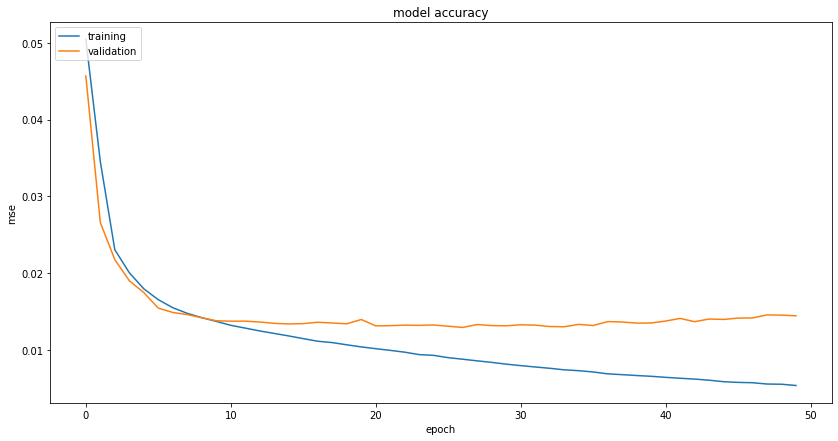

In [25]:
plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])
plt.title('model accuracy')
plt.ylabel('mse')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='upper left')
plt.show()

In [26]:
#
#
# TESTING
#
#

In [27]:
# curve smoothing parameters
window_length = 25
polyorder = 3

# mean squared/absolute total error sum variables
mse_ed_total_error, mse_es_total_error = 0, 0
mae_ed_total_error, mae_es_total_error = 0, 0

for sample in test_set.values:
  # getting true values
  _, directory, file_name, extension, ed, es = sample

  # getting predicted values
  X = np.array([np.load(extracted_dir + file_name + ".npy")])
  raw_pred_y = savgol_filter(lstm.predict(X)[0], window_length, polyorder)

  # locating peaks
  pred_ed_idx, pred_ed_val = max(enumerate(-raw_pred_y), key=operator.itemgetter(1)) 
  pred_es_idx, pred_es_val = max(enumerate(raw_pred_y), key=operator.itemgetter(1)) 

  # calculating mean squared error for sample
  mse_ed_total_error += ((ed - pred_ed_idx) ** 2)
  mse_es_total_error += ((es - pred_es_idx) ** 2)
  # calculating mean absolute error for sample
  mae_ed_total_error += abs(ed - pred_ed_idx)
  mae_es_total_error += abs(es - pred_es_idx)

In [28]:
# finalising mean squared/asbolute error
count = len(test_set)
mse_ed = (1 / count) * mse_ed_total_error
mse_es = (1 / count) * mse_es_total_error
mae_ed = (1 / count) * mae_ed_total_error
mae_es = (1 / count) * mae_es_total_error

print(f"mse - mean squared error  : ed = {mse_ed}, es = {mse_es}")
print(f"mae - mean absolute error : ed = {mae_ed}, es = {mae_es}")

mse - mean squared error  : ed = 16.821782178217823, es = 14.970297029702971
mae - mean absolute error : ed = 2.5346534653465347, es = 2.4257425742574257


In [29]:
#
#
# PREDICTION
#
#

In [30]:
def predict_sample(test_sample):
  _, directory, file_name, extension, ed, es = test_sample
  samp = np.load(extracted_dir + file_name + extension)
  pred_y = lstm.predict(np.array([samp]))
  plt.plot(np.arange(0, len(pred_y[0])), pred_y[0])
  plt.show()

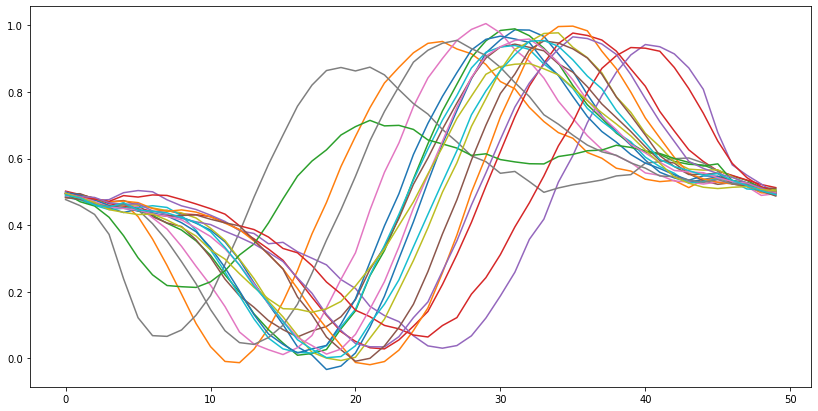

In [31]:
for sample in test_set.values[:20]:
  _, directory, file_name, extension, ed, es = sample
  samp = np.load(extracted_dir + file_name + extension)
  pred_y = lstm.predict(np.array([samp]))
  plt.plot(np.arange(0, len(pred_y[0])), pred_y[0])

plt.show()

In [32]:
#
#
# FINALISATION
#
#

In [33]:
# # loading weights if applicable
# lstm.save_weights(weight_path)

In [34]:
# np.save(weight_path + "history.npy", history.history)